In [354]:
# Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import plotly.express as px
import plotly.colors
import plotly.io as pio

pio.orca.config.save()
import plotly.graph_objects as go
pio.templates.default = "plotly_white"

from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

## **Load and Prepare Data**

In [355]:
# Load the dataset with only the specified columns
df = pd.read_csv('../data/raw/online_retail.csv' )
print(df.shape)
df.head(3)

(541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/10 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/10 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/10 8:26,2.75,17850.0,United Kingdom


In [356]:
# Inspect data
print("\nDataset Information:")
print(df.info())

print("\nDescriptive statistics:")
df.describe()


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB
None

Descriptive statistics:


,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


Up to this point, we can spot some columns with invalid values. We have `Quantity`, `UnitPrice` having negative values which can have very damaging effects to our analysis if left unchecked. We can also tell the two columns are very high skew which can be a result of these invalid values. We'll do an inspection of both columns to see what we can uncover.

Let's start our preprocessing step by handling the invalid records in our data

In [357]:
# Filter records with UnitPrice <= 0 or Quantity <= 0
invalid_records = df[(df['UnitPrice'] <= 0.009) | (df['Quantity'] <= 0)]

# Drop rows that exist in invalid_records
df_valid = df[~df.index.isin(invalid_records.index)]

In [358]:
# Data Cleaning
# Checking for missing values
print("\nMissing values per column:")
print(df_valid.isnull().sum())
df_valid.dropna(inplace=True)

# Convert InvoiceDate date to datetime format
df_valid['InvoiceDate'] = pd.to_datetime(df_valid['InvoiceDate'])

# Split into separate Date and Time columns
df_valid['Date'] = df_valid['InvoiceDate'].dt.date    # Extract the date
df_valid['Time'] = df_valid['InvoiceDate'].dt.time    # Extract the time

# Define the analysis date
# Using the day after the latest purchase date in the dataset
analysis_date = df_valid['InvoiceDate'].max() + pd.DateOffset(1)
print(f"\nAnalysis Date (day after the last purchase): {analysis_date}")

# Set UnitPrice columns to 2decimals
df_valid['UnitPrice'] = df_valid['UnitPrice'].round(2)

# Convert customer id to string
df_valid['CustomerID'] = df_valid['CustomerID'].astype(int) # Eliminate the decimal
df_valid['CustomerID'] = df_valid['CustomerID'].astype(str)

# Create Transaction amount column
df_valid['TransactionAmount'] = (df_valid['UnitPrice'] * df_valid['Quantity']).round(2)

# Final check on cleaned data
print("\nCleaned Dataset Info:")
print(df_valid.info())


Missing values per column:
InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132220
Country             0
dtype: int64

Analysis Date (day after the last purchase): 2011-12-10 12:50:00

Cleaned Dataset Info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 397880 entries, 0 to 541908
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   InvoiceNo          397880 non-null  object        
 1   StockCode          397880 non-null  object        
 2   Description        397880 non-null  object        
 3   Quantity           397880 non-null  int64         
 4   InvoiceDate        397880 non-null  datetime64[ns]
 5   UnitPrice          397880 non-null  float64       
 6   CustomerID         397880 non-null  object        
 7   Country            397880 non-null  object        
 8   Date              

In the cell above, we've done the following:

* Handled invalid entries in columns Quantity & UnitPrice
* Dropped null values
* Converted InvoiceDate to datetime format and created Date and Time column
* Set the analysis date/reference date for Recency measure (1 day after last purchase)
* Converted CustomerID column into string format
* Added TransactionAmount column

**Note**: Why Keep Both Date and Time Columns? (*Incase purposes*)
- The Date column allows for broader time-based grouping, such as daily or monthly sales analysis.
- The Time column allows for finer-grained analysis, such as identifying peak shopping hours or transaction patterns within a day.

We'll perform validation checks on the stubborn columns to confirm the data is exactly how we want it

In [359]:
df_valid.describe()

,Quantity,UnitPrice,TransactionAmount
count,397880.000000,397880.000000,397880.000000
mean,12.988358,3.116519,22.397225
std,179.332672,22.097986,309.072587
min,1.000000,0.040000,0.060000
25%,2.000000,1.250000,4.680000
50%,6.000000,1.950000,11.800000
75%,12.000000,3.750000,19.800000
max,80995.000000,8142.750000,168469.600000


**Inspecting UnitPrice column**

We saw `UnitPrice` had some unpleasant values, we'll try viewing those columns with invalid values to confirm our data is ok. Of course we'll not be looking at `TransactionAmount` since it's a *secondary column* `UnitPrice` column and `Quantity`

In [360]:
# DataFrame with UnitPrice as Zero
unitprice_zero = df_valid.loc[df['UnitPrice'].sort_values() <= 0]
unitprice_zero

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,TransactionAmount


In [361]:
# Inspect UnitPrice values
df_valid['UnitPrice'].value_counts().sort_index(ascending=False)

8142.75      1
4161.06      2
3949.32      1
3155.95      1
2500.00      1
          ... 
0.09         2
0.08        55
0.07         7
0.06       112
0.04        66
Name: UnitPrice, Length: 439, dtype: int64

**Inspecting Quantity Amount**

In [362]:
qty_invalid = df_valid.loc[df['Quantity'].sort_values() < 1]
qty_invalid

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Date,Time,TransactionAmount


In [363]:
# Inspect Quantity values
df_valid['Quantity'].value_counts().sort_index(ascending=False)

80995        1
74215        1
4800         1
4300         1
3906         1
         ...  
5         8148
4        32180
3        26948
2        57999
1        73297
Name: Quantity, Length: 301, dtype: int64

We can see there's a very huge difference between the item prices, the most expensive item costs around 8,142 whereas the cheapest in our dataset is about 0.04 after validating our dataset. As for the invalid values, we had zero entries for both UnitPrice and Quantity checks; there are no negative values in the cleaned dataset meaning we are set for the next step.

In [364]:
# Save cleaned data
df_valid.to_pickle('../data/processed/cleaned_data.pkl')

In [365]:
# pkl_file = pd.read_pickle('../data/processed/cleaned_data.pkl')
# pkl_file.shape

## **Calculate RFM Metrics**

1. **Define the Reference Date**:

Set a date to calculate recency (e.g., the last date in the dataset + 1 day).

In [366]:
# Reference date
analysis_date

Timestamp('2011-12-10 12:50:00')

2. **Calculate R, F, and M**:

- **Recency**: Days since the customer’s last transaction.
- **Frequency**: Number of transactions per customer.
- **Monetary**: Total spending per customer.

In [367]:
# Calculate RFM metrics
rfm = df_valid.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (analysis_date - x.max()).days),  # Days since last purchase
    Frequency=('InvoiceNo', 'nunique'),# Number of unique invoices
    Monetary=('TransactionAmount', 'sum')  # Total transaction amount
).reset_index()


# Verify the RFM DataFrame
print("\nRFM Table (Preview):")
print(rfm.head())


RFM Table (Preview):
  CustomerID  Recency  Frequency  Monetary
0      12346      326          1  77183.60
1      12347        2          7   4310.00
2      12348       75          4   1797.24
3      12349       19          1   1757.55
4      12350      310          1    334.40


**Distributions of RFM Metrics**

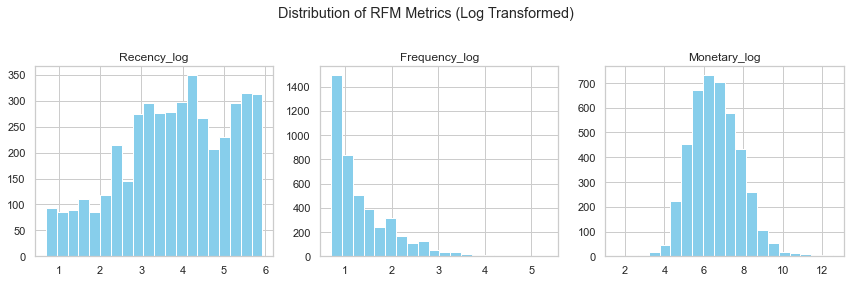

In [368]:
# Apply log transformation to handle the skew values
rfm['Recency_log'] = np.log1p(rfm['Recency'])
rfm['Frequency_log'] = np.log1p(rfm['Frequency'])
rfm['Monetary_log'] = np.log1p(rfm['Monetary'])

# Plot histograms for Recency, Log Frequency, and Log Monetary
rfm[['Recency_log', 'Frequency_log', 'Monetary_log']].hist(
    bins=20, 
    layout=(1, 3), 
    figsize=(12, 4), 
    color='skyblue'
)
plt.suptitle('Distribution of RFM Metrics (Log Transformed)')
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [369]:
# Checking skewness after transformation
print(rfm[['Recency_log', 'Frequency_log', 'Monetary_log']].skew())

Recency_log     -0.379169
Frequency_log    1.208652
Monetary_log     0.393553
dtype: float64


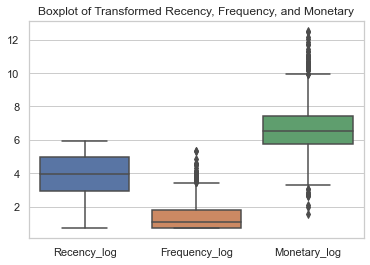

In [370]:
# Plotting boxplots for transformed Frequency and Monetary
sns.boxplot(data=rfm[['Recency_log','Frequency_log', 'Monetary_log']])
plt.title('Boxplot of Transformed Recency, Frequency, and Monetary')
plt.show()

## RFM Scoring

In [371]:
# Recency scoring (higher score for lower recency values - recent purchases)
rfm['Recency_score'] = pd.qcut(rfm['Recency_log'], 5, labels=[5, 4, 3, 2, 1])

# Frequency scoring (higher score for higher frequency values)
rfm['Frequency_score'] = pd.qcut(rfm['Frequency_log'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Monetary scoring (higher score for higher monetary values)
rfm['Monetary_score'] = pd.qcut(rfm['Monetary_log'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])

# Combine the scores into a single RFM score
rfm['RFM_score'] = (
    rfm['Recency_score'].astype(int) + 
    rfm['Frequency_score'].astype(int) + 
    rfm['Monetary_score'].astype(int)
)

# Preview the RFM table with scores
print("\nRFM Table with Scores (Preview):")
rfm[['CustomerID', 'Recency_log', 'Frequency_log', 'Monetary_log', 'Recency_score', 'Frequency_score', 'Monetary_score', 'RFM_score']].head()


RFM Table with Scores (Preview):


,CustomerID,Recency_log,Frequency_log,Monetary_log,Recency_score,Frequency_score,Monetary_score,RFM_score
0,12346,5.789960,0.693147,11.253955,1,1,5,7
1,12347,1.098612,2.079442,8.368925,5,5,5,15
2,12348,4.330733,1.609438,7.494564,2,4,4,10
3,12349,2.995732,0.693147,7.472245,4,1,4,9
4,12350,5.739793,0.693147,5.815324,1,1,2,4


## RFM Value Segmentation

In [372]:
# Create RFM segments based on the RFM score
segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
rfm['Value Segment'] = pd.qcut(rfm['RFM_score'], q=3, labels=segment_labels)
# Preview
rfm.head()

,CustomerID,Recency,Frequency,Monetary,Recency_log,Frequency_log,Monetary_log,Recency_score,Frequency_score,Monetary_score,RFM_score,Value Segment
0,12346,326,1,77183.60,5.789960,0.693147,11.253955,1,1,5,7,Low-Value
1,12347,2,7,4310.00,1.098612,2.079442,8.368925,5,5,5,15,High-Value
2,12348,75,4,1797.24,4.330733,1.609438,7.494564,2,4,4,10,Mid-Value
3,12349,19,1,1757.55,2.995732,0.693147,7.472245,4,1,4,9,Mid-Value
4,12350,310,1,334.40,5.739793,0.693147,5.815324,1,1,2,4,Low-Value


In [373]:
# RFM Segment Distribution
cust_segment_count = rfm['Value Segment'].value_counts().reset_index()
# Assign column names
cust_segment_count.columns = ['Value Segment', 'Count']

pastel_colors = px.colors.qualitative.Pastel

# Create the bar chart
fig_segment_dist = px.bar(cust_segment_count, x='Value Segment', y='Count', 
                          color='Value Segment', color_discrete_sequence=pastel_colors,
                          title='RFM Value Segment Distribution')

# Update the layout
fig_segment_dist.update_layout(xaxis_title='RFM Value Segment',
                              yaxis_title='Count',
                              showlegend=False)

# Show the figure
fig_segment_dist.show()
fig_segment_dist.write_image('../images/rfm_value_segment_dist.png', width=800, height=600)

## Customer Segmentation

In [374]:
# Define segments based on ranges of the total RFM score
def aggregate_segment(row):
    if row['RFM_score'] >= 13:
        return 'Champions'
    elif row['RFM_score'] >= 10:
        return 'Loyal Customers'
    elif row['RFM_score'] >= 7:
        return 'Potential Loyalists'
    elif row['RFM_score'] >= 5:
        return 'At Risk'
    else:
        return 'Hibernating'

# Apply the segmentation function to each row
rfm['RFM Customer Segment'] = rfm.apply(aggregate_segment, axis=1)

# Check the segment distribution
print("\nSegment Distribution:")
print(rfm['RFM Customer Segment'].value_counts())

# Preview the RFM table with segments
print("\nRFM Table with Aggregated Score Segments (Preview):")
rfm[['CustomerID', 'RFM_score', 'RFM Customer Segment']].head()



Segment Distribution:
Potential Loyalists    1092
Loyal Customers        1008
Champions               934
At Risk                 759
Hibernating             545
Name: RFM Customer Segment, dtype: int64

RFM Table with Aggregated Score Segments (Preview):


,CustomerID,RFM_score,RFM Customer Segment
0,12346,7,Potential Loyalists
1,12347,15,Champions
2,12348,10,Loyal Customers
3,12349,9,Potential Loyalists
4,12350,4,Hibernating


In [375]:
pastel_colors = plotly.colors.qualitative.Pastel

segment_counts = rfm['RFM Customer Segment'].value_counts()

# Create a bar chart to compare segment counts
fig = go.Figure(data=[go.Bar(x=segment_counts.index, y=segment_counts.values,
                            marker=dict(color=pastel_colors))])

# Set the color of the Champions segment as a different color
champions_color = 'rgb(158, 202, 225)'
fig.update_traces(marker_color=[champions_color if segment == 'Champions' else pastel_colors[i]
                                for i, segment in enumerate(segment_counts.index)],
                  marker_line_color='rgb(8, 48, 107)',
                  marker_line_width=1.5, opacity=0.6)

# Update the layout
fig.update_layout(title='Comparison of RFM Segments',
                  xaxis_title='RFM Segments',
                  yaxis_title='Number of Customers',
                  showlegend=False)

fig.show()
fig.write_image('../images/rfm_segments_comparison.png', width=800, height=600)

## RFM Analysis

In [376]:
segment_product_counts = rfm.groupby(['Value Segment', 'RFM Customer Segment']).size().reset_index(name='Count')

segment_product_counts = segment_product_counts.sort_values('Count', ascending=False)

fig_treemap_segment_product = px.treemap(segment_product_counts, 
                                         path=['Value Segment', 'RFM Customer Segment'], 
                                         values='Count',
                                         color='Value Segment', color_discrete_sequence=px.colors.qualitative.Pastel,
                                         title='RFM Customer Segments by Value')
fig_treemap_segment_product.show()
fig_treemap_segment_product.write_image('../images/figtree_segment_by_value.png', width=800, height=600)

In [377]:
# Save RFM table
rfm.to_pickle('../data/processed/rfm_table.pkl')

Analyzing RFM scores across all customer segments

In [378]:
rfm['Recency_score'] = rfm['Recency_score'].astype(int)
rfm['Frequency_score'] = rfm['Frequency_score'].astype(int)
rfm['Monetary_score'] = rfm['Monetary_score'].astype(int)

# Calculate the average Recency, Frequency, and Monetary scores for each segment
segment_scores = rfm.groupby('RFM Customer Segment')[['Recency_score', 'Frequency_score', 'Monetary_score']].mean().reset_index()

# Create a grouped bar chart to compare segment scores
fig = go.Figure()

# Add bars for Recency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segment'],
    y=segment_scores['Recency_score'],
    name='Recency Score',
    marker_color='rgb(158,202,225)'
))

# Add bars for Frequency score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segment'],
    y=segment_scores['Frequency_score'],
    name='Frequency Score',
    marker_color='rgb(94,158,217)'
))

# Add bars for Monetary score
fig.add_trace(go.Bar(
    x=segment_scores['RFM Customer Segment'],
    y=segment_scores['Monetary_score'],
    name='Monetary Score',
    marker_color='rgb(32,102,148)'
))

# Update the layout
fig.update_layout(
    title='Comparison of RFM Segments based on Recency, Frequency, and Monetary Scores',
    xaxis_title='RFM Segments',
    yaxis_title='Score',
    barmode='group',
    showlegend=True
)

fig.show()
fig.write_image('../images/rfm_comparisons.png', width=800, height=600)